The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.15.0


# Networks with Parallel Concatenations (GoogLeNet)
:label:`sec_googlenet`

In 2014, *GoogLeNet*
won the ImageNet Challenge, proposing a structure
that combined the strengths of NiN and  paradigms of repeated blocks :cite:`Szegedy.Liu.Jia.ea.2015`.
One focus of the paper was to address the question
of which sized convolution kernels are best.
After all, previous popular networks employed choices
as small as $1 \times 1$ and as large as $11 \times 11$.
One insight in this paper was that sometimes
it can be advantageous to employ a combination of variously-sized kernels.
In this section, we will introduce GoogLeNet,
presenting a slightly simplified version of the original model:
we
omit a few ad-hoc features that were added to stabilize training
but are unnecessary now with better training algorithms available.


## Inception Blocks

The basic convolutional block in GoogLeNet is called an *Inception block*,
likely named due to a quote from the movie *Inception* ("We need to go deeper"),
which launched a viral meme.

![Structure of the Inception block.](http://d2l.ai/_images/inception.svg)
:label:`fig_inception`

As depicted in :numref:`fig_inception`,
the inception block consists of four parallel paths.
The first three paths use convolutional layers
with window sizes of $1\times 1$, $3\times 3$, and $5\times 5$
to extract information from different spatial sizes.
The middle two paths perform a $1\times 1$ convolution on the input
to reduce the number of channels, reducing the model's complexity.
The fourth path uses a $3\times 3$ maximum pooling layer,
followed by a $1\times 1$ convolutional layer
to change the number of channels.
The four paths all use appropriate padding to give the input and output the same height and width.
Finally, the outputs along each path are concatenated
along the channel dimension and comprise the block's output.
The commonly-tuned hyperparameters of the Inception block
are the number of output channels per layer.


In [1]:
from d2l import torch as d2l
import torch
from torch import nn
from torch.nn import functional as F

class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

To gain some intuition for why this network works so well,
consider the combination of the filters.
They explore the image in a variety of filter sizes.
This means that details at different extents
can be recognized efficiently by filters of different sizes.
At the same time, we can allocate different amounts of parameters
for different filters.


## GoogLeNet Model

As shown in :numref:`fig_inception_full`, GoogLeNet uses a stack of a total of 9 inception blocks
and global average pooling to generate its estimates.
Maximum pooling between inception blocks reduces the dimensionality.
The first module is similar to AlexNet and LeNet.
The stack of blocks is inherited from VGG
and the global average pooling avoids
a stack of fully-connected layers at the end.

![The GoogLeNet architecture.](../img/inception-full.svg)
:label:`fig_inception_full`

We can now implement GoogLeNet piece by piece.
The first module uses a 64-channel $7\times 7$ convolutional layer.


In [2]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The second module uses two convolutional layers:
first, a 64-channel $1\times 1$ convolutional layer,
then a $3\times 3$ convolutional layer that triples the number of channels. This corresponds to the second path in the Inception block.


In [3]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The third module connects two complete Inception blocks in series.
The number of output channels of the first Inception block is
$64+128+32+32=256$,
and the number-of-output-channel ratio
among the four paths is $64:128:32:32=2:4:1:1$.
The second and third paths first reduce the number of input channels
to $96/192=1/2$ and $16/192=1/12$, respectively,
and then connect the second convolutional layer.
The number of output channels of the second Inception block
is increased to $128+192+96+64=480$, and the number-of-output-channel ratio
among the four paths is $128:192:96:64 = 4:6:3:2$.
The second and third paths first reduce the number of input channels
to $128/256=1/2$ and $32/256=1/8$, respectively.


In [4]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The fourth module is more complicated.
It connects five Inception blocks in series,
and they have $192+208+48+64=512$, $160+224+64+64=512$,
$128+256+64+64=512$, $112+288+64+64=528$,
and $256+320+128+128=832$ output channels, respectively.
The number of channels assigned to these paths is similar
to that in the third module:
the second path with the $3\times 3$ convolutional layer
outputs the largest number of channels,
followed by the first path with only the $1\times 1$ convolutional layer,
the third path with the $5\times 5$ convolutional layer,
and the fourth path with the $3\times 3$ maximum pooling layer.
The second and third paths will first reduce
the number of channels according to the ratio.
These ratios are slightly different in different Inception blocks.


In [5]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The fifth module has two Inception blocks with $256+320+128+128=832$
and $384+384+128+128=1024$ output channels.
The number of channels assigned to each path
is the same as that in the third and fourth modules,
but differs in specific values.
It should be noted that the fifth block is followed by the output layer.
This block uses the global average pooling layer
to change the height and width of each channel to 1, just as in NiN.
Finally, we turn the output into a two-dimensional array
followed by a fully-connected layer
whose number of outputs is the number of label classes.


In [6]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveMaxPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

The GoogLeNet model is computationally complex,
so it is not as easy to modify the number of channels as in VGG.
To have a reasonable training time on Fashion-MNIST,
we reduce the input height and width from 224 to 96.
This simplifies the computation.
The changes in the shape of the output
between the various modules are demonstrated below.


In [7]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


## Training

As before, we train our model using the Fashion-MNIST dataset.
 We transform it to $96 \times 96$ pixel resolution
 before invoking the training procedure.


loss 0.232, train acc 0.914, test acc 0.896
2787.0 examples/sec on cuda:0


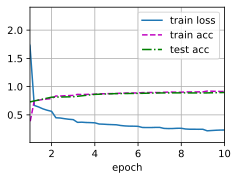

In [8]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

## Summary

* The Inception block is equivalent to a subnetwork with four paths. It extracts information in parallel through convolutional layers of different window shapes and maximum pooling layers. $1 \times 1$ convolutions reduce channel dimensionality on a per-pixel level. Maximum pooling reduces the resolution.
* GoogLeNet connects multiple well-designed Inception blocks with other layers in series. The ratio of the number of channels assigned in the Inception block is obtained through a large number of experiments on the ImageNet dataset.
* GoogLeNet, as well as its succeeding versions, was one of the most efficient models on ImageNet, providing similar test accuracy with lower computational complexity.

## Exercises

1. There are several iterations of GoogLeNet. Try to implement and run them. Some of them include the following:
    * Add a batch normalization layer :cite:`Ioffe.Szegedy.2015`, as described
      later in :numref:`sec_batch_norm`.
    * Make adjustments to the Inception block
      :cite:`Szegedy.Vanhoucke.Ioffe.ea.2016`.
    * Use label smoothing for model regularization
      :cite:`Szegedy.Vanhoucke.Ioffe.ea.2016`.
    * Include it in the residual connection
      :cite:`Szegedy.Ioffe.Vanhoucke.ea.2017`, as described later in
      :numref:`sec_resnet`.
1. What is the minimum image size for GoogLeNet to work?
1. Compare the model parameter sizes of AlexNet, VGG, and NiN with GoogLeNet. How do the latter two network architectures significantly reduce the model parameter size?


[Discussions](https://discuss.d2l.ai/t/82)
